<h1>Pit Stop Optimizer</h1>
<h2>Run last cell to install dependancies</h2>
<h2>For running only the pretrained model, run all cells before the "Train Model" section, and skip to "Final Model"</h2>

<h3>To train a new model, run until "Save Model". Saving will overrite the existing model. Other instructions are in cell comments</h3>

<h2>Imports</h2>

In [2]:
import os
import math
from typing import List
from IPython.utils import io

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from scipy.stats import linregress

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML

### Disabled -- Not needed for project submission
### Uncomment for training purposes and fetching new race data
# import fastf1
# import requests
# import json
###

<h2>Directories</h2>

In [3]:
race_dir = './Race Data/'
val_dir = './Validation Data/'
model_path = './Pit_Stop_Model.pt'

### Disabled -- Not needed for project submission
### Uncomment for training purposes and fetching new race data
###     will not work when running off GitHub
###     clone repository, create "cache" directory, and update <PATH> with cache location
# fastf1.Cache.enable_cache('<PATH>') 
###


<h2>Utilities</h2>

In [4]:
# global scalers
global mmt
mmt = MinMaxScaler()
global mmf
mmf = MinMaxScaler()

# maps for column conversions
size = 10
racehash = [{} for h in range(size)]
pitmap = {}
yearmap = {}
drivermap = {}
tiremap = {'SUPERSOFT':0,'SOFT':1,'MEDIUM':2,'HARD':3,'INTERMEDIATE':4,'WET':5,'UNKNOWN':6}

# year range to gather data -- reduces lookup time
years = [y for y in range(2012,2023)]

<h2>General Functions</h2>

In [5]:
# pull data from csv files
def get_lap_times():
    lap_times = pd.read_csv(race_dir + 'lap_times.csv')
    return lap_times
def get_pit_stops():
    pit_stops = pd.read_csv(race_dir + 'pit_stops.csv')
    return pit_stops
def get_drivers():
    drivers = pd.read_csv(race_dir + 'drivers.csv')
    return drivers
def get_races():
    races = pd.read_csv(race_dir + 'races.csv')
    return races
def get_circuits():
    circuits = pd.read_csv(race_dir + 'circuits.csv')
    return circuits

# Add column for number of laps until next pit stop
def get_laps_left(raceId: int, driverId: str, lap: int) -> int:
    last_lap = lap_times['lap'][(lap_times['raceId'] == raceId) & (lap_times['driverId'] == driverId)].nlargest().iloc[0]
    try:
        stops = pitmap[raceId][driverId]
        stops_num = len(stops.keys())
        stop = 1
        while lap > stops[stop] and stop < stops_num:
            stop += 1
        res = stops[stop] - lap
        if res < 0:
            res = last_lap - lap
    except:
        res = last_lap - lap
    return res

# add {raceId:{driverId:{pit stop num:lap num}}} to pitmap
def map_pits():
    for idx,row in pit_stops.iterrows():
        raceId = row.raceId
        driverId = row.driverId
        stop = row.stop
        lap = row.lap
        if raceId not in pitmap.keys():
            pitmap[raceId] = {}
        if driverId not in pitmap[raceId].keys():
            pitmap[raceId][driverId] = {}
        pitmap[raceId][driverId][stop] = lap

# add {raceId:circuitId} to race hash
def get_hash_key(raceId):
    return raceId % size
def hash_raceId(raceId: int(),circuit: str()):
    key = get_hash_key(raceId)
    racehash[key].update({raceId:circuit})
def get_circuit(raceId):
    key = get_hash_key(raceId)
    return racehash[key][raceId]

# get driver number by driverId
def map_driver(driverId: int) -> int:
    return drivermap[driverId]

### Data Transformation Functions
def scale_data(data):
    data = mmf.fit_transform(data.iloc[:, 4:-1])
    data = Variable(torch.Tensor(data)) 
    data = torch.reshape(data, (data.shape[0], 1, data.shape[1])) 
    return data

def unscale_predicted(predicted):
    predicted = predicted.data.numpy() 
    predicted = mmt.inverse_transform(predicted)
    predicted = np.round(predicted,0)
    return predicted

def format_target(target):
    target = mmt.transform(target.iloc[:, -1:])
    target = Variable(torch.Tensor(target))
    target = target.data.numpy()
    target = mmt.inverse_transform(target)
    return target

def get_projected_pit_lap(data):
    data = data.ravel()
    regress = linregress(np.linspace(0,len(data),len(data)),data)
    slope = regress.slope
    intercept = regress.intercept
    x = (intercept * -1)/slope
    return x.round()


In [6]:
# pull data into dataframes
lap_times = pd.DataFrame(get_lap_times())
races = pd.DataFrame(get_races())
circuits = pd.DataFrame(get_circuits())
pit_stops = pd.DataFrame(get_pit_stops())
drivers = pd.DataFrame(get_drivers())

In [7]:
# populate yearmap with raceId:year dicts
for idx,row in races.iterrows():
    yearmap.update({row.raceId:row.year})
    
# reduce 'races' size to year range
races = races.loc[races['year'] >= min(years)]


In [8]:
# get circuitId for each race
for idx,row in races.iterrows():
    hash_raceId(row['raceId'],row['circuitId'])

In [9]:
# add circuitId to lap_times, keep rows for races in year range
lap_times['circuitId'] = lap_times['raceId'].map(lambda r: get_circuit(int(r)))
lap_times['year'] = lap_times['raceId'].map(yearmap)
lap_times = lap_times.loc[lap_times['year'] >= min(years)]
lap_times

,raceId,driverId,lap,position,time,milliseconds,circuitId,year
0,948,20,1,1,01:36.9,96916,1,2016
1,948,20,2,1,01:31.7,91664,1,2016
2,948,20,3,1,01:32.2,92167,1,2016
3,948,20,4,1,01:32.0,92014,1,2016
4,948,20,5,1,01:32.3,92273,1,2016
...,...,...,...,...,...,...,...,...
156303,1096,822,53,16,01:33.0,92998,24,2022
156304,1096,822,54,16,01:33.0,92995,24,2022
156305,1096,822,55,16,01:31.2,91236,24,2022
156306,1096,822,56,15,01:30.6,90566,24,2022


In [10]:
# set target race and driver
circuit = 'Silverstone'
year = 2022
driverId = 1

In [11]:
# get circuitId from circuit name
circuitId = circuits.loc[circuits['circuitRef'] == circuit.lower()]
circuitId = circuitId['circuitId'].values[0]

In [12]:
# get pit stop laps for target race & driver
pit_stops.loc[(pit_stops['raceId'] == circuitId) & (pit_stops['driverId'] == driverId)]
pit_stops['year'] = pit_stops['raceId'].map(yearmap)
pit_stops = pit_stops.loc[pit_stops['year']>=min(years)]

In [13]:
# call to populate pitmap
map_pits()

<h3>Next cell requires cache access. Only run if fetching new data and cache directory exists</h3>

In [14]:
## DO NOT RUN WITHOUT CACHE DIRECTORY AND CACHE ENABLED

# # query Ergast DB for target race data
# race = fastf1.get_session(year, circuit.lower(), 5)
# race.load()

# # convert lap data to pandas DF and save as csv for persistance
# df = pd.DataFrame(race.laps)
# df.to_csv(f'{race_dir}{circuit}_{year}_Laps.csv')
# ######


In [15]:
# get saved Ergast data. If not found, enable fastf1 cache and run cell above
race = pd.read_csv(f'{race_dir}{circuit}_{year}_Laps.csv')

# convert LapNumber column to integers
race.LapNumber = race.LapNumber.astype(int)

In [16]:
# Isolate target race from lap_times
data = lap_times.loc[(lap_times['circuitId'] == circuitId) & (lap_times['driverId'] == driverId) & (lap_times['year'] == year)]

# Add columns for laps left to pit, and constant total laps in race
data['laps_to_pit'] = list(map(get_laps_left, data['raceId'], data['driverId'], data['lap']))
data['total_laps'] = max(data['lap'])

/var/folders/gt/zr44j_q13h51pxlwmh9f0rgw0000gn/T/ipykernel_73982/4217261406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['laps_to_pit'] = list(map(get_laps_left, data['raceId'], data['driverId'], data['lap']))
/var/folders/gt/zr44j_q13h51pxlwmh9f0rgw0000gn/T/ipykernel_73982/4217261406.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['total_laps'] = max(data['lap'])


In [17]:
# data.head(10)

In [18]:
# populate drivermap
for idx,row in drivers.iterrows():
    id = row.driverId
    num = row.number
    drivermap.update({id:num})

# add driver number column, map to driverId
data['driverNum'] = data['driverId'].map(drivermap)  

# get tire compound for each lap from Ergast data
compounds = []
for idx,row in data.iterrows():
    dr = row.driverNum
    lap = row.lap
    srow = race.loc[(race['DriverNumber'] == dr) & (race['LapNumber'] == lap)]
    compound = srow.Compound.values[0]
    compounds.append(tiremap[compound])
data = data.assign(compound=compounds)

# prepare data for model
data = data[['raceId','year','driverId','position','milliseconds','total_laps','lap','compound','laps_to_pit']]

# first lap is grid 'Formation Lap'. not needed
data = data.loc[data['lap'] > 3]

#save data to csv for quick future reference
data.to_csv(f'{val_dir}{circuit}_{year}_Test_Data.csv', index=False)


/var/folders/gt/zr44j_q13h51pxlwmh9f0rgw0000gn/T/ipykernel_73982/1206915291.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['driverNum'] = data['driverId'].map(drivermap)


In [19]:
data.head(10)

,raceId,year,driverId,position,milliseconds,total_laps,lap,compound,laps_to_pit
142610,1083,2022,1,6,95270,52,4,2,29
142611,1083,2022,1,6,95120,52,5,2,28
142612,1083,2022,1,4,93731,52,6,2,27
142613,1083,2022,1,4,93955,52,7,2,26
142614,1083,2022,1,4,93679,52,8,2,25
142615,1083,2022,1,4,93704,52,9,2,24
142616,1083,2022,1,4,93338,52,10,2,23
142617,1083,2022,1,4,93335,52,11,2,22
142618,1083,2022,1,4,94090,52,12,2,21
142619,1083,2022,1,3,93212,52,13,2,20


<h2>Data Visualizations</h2>

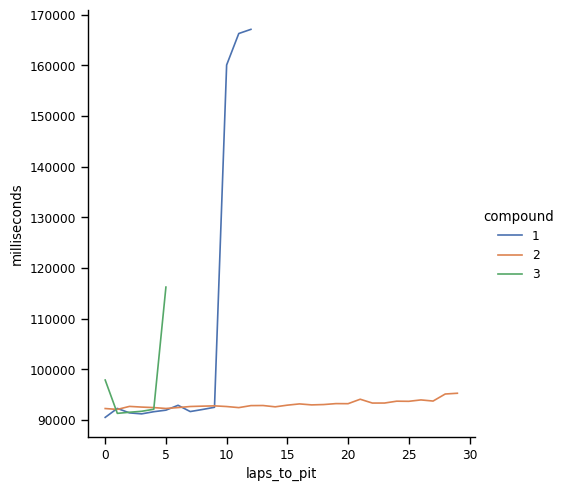

In [20]:
# desc_method = sns.load_dataset("data")
sns.set_context("paper")
sns.relplot(data=data, x="laps_to_pit", y="milliseconds", hue="compound", kind='line', palette="deep")

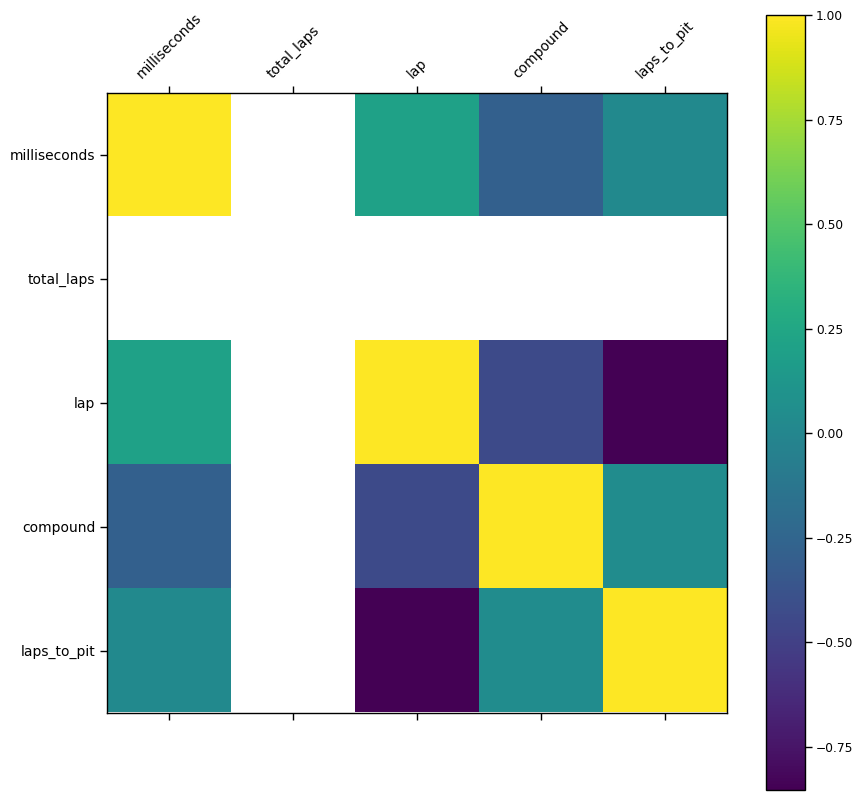

In [21]:
fig = plt.figure(figsize=(10, 10))
vis_data = data.iloc[:,4:]
plt.matshow(vis_data.corr(),fignum=fig.number)
plt.xticks(range(vis_data.select_dtypes(['number']).shape[1]), vis_data.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(vis_data.select_dtypes(['number']).shape[1]), vis_data.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
plt.show()

In [22]:
Kmean = KMeans(n_clusters=2)
Kmean.fit(vis_data)
clusters = Kmean.cluster_centers_
clusters

array([[1.64452333e+05, 5.20000000e+01, 4.10000000e+01, 1.00000000e+00,
        1.10000000e+01],
       [9.32996739e+04, 5.20000000e+01, 2.71521739e+01, 1.91304348e+00,
        1.07608696e+01]])

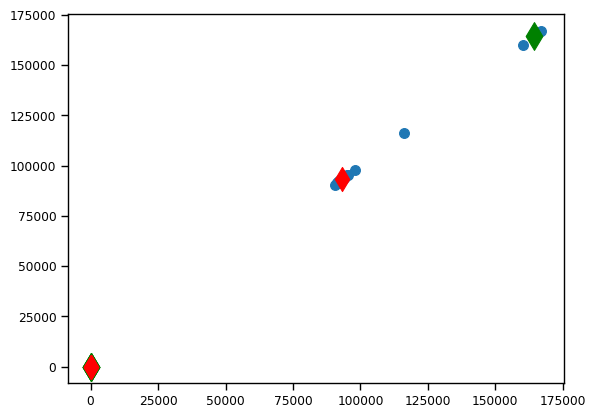

In [23]:
plt.scatter(vis_data, vis_data, s = 50)
plt.scatter(clusters[0],clusters[0], s=200, c='g', marker='d')
plt.scatter(clusters[1],clusters[1], s=150, c='r', marker='d')
plt.show()

In [24]:
Kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int32)

# Scale Training Data

In [25]:
# Where to split train/test (percentage)
perc = .8

In [26]:
# Split features & target columns
features = data.iloc[:,4:-1]
target = data.iloc[:,-1:]

# Scale features & target
features_scaled = mmf.fit_transform(features)
target_scaled = mmt.fit_transform(target) 

train_lim = math.ceil(features_scaled.shape[0] * perc)

# Split train & test data rows
features_train = features_scaled[:train_lim, :]
features_test = features_scaled[train_lim:, :]
target_train = target_scaled[:train_lim, :]
target_test = target_scaled[train_lim:, :] 

# Final conversion and reshape for model training/testing
features_train_tensors = Variable(torch.Tensor(features_train))
features_test_tensors = Variable(torch.Tensor(features_test))

target_train = Variable(torch.Tensor(target_train))
target_test = Variable(torch.Tensor(target_test)) 

train_data = torch.reshape(features_train_tensors,   (features_train_tensors.shape[0], 1, features_train_tensors.shape[1]))
test_data = torch.reshape(features_test_tensors,  (features_test_tensors.shape[0], 1, features_test_tensors.shape[1])) 


# Model

In [27]:
# Machine Learning Model (LSTM)
class LSTM(nn.Module):
    def __init__(self, num_classes=1, input_size=4, hidden_size=75, num_layers=1):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lin_1 =  nn.Linear(hidden_size, 300)
        self.lin = nn.Linear(300, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.lin_1(out)
        out = self.relu(out)
        out = self.lin(out)
        return out

    def save(self,model_path):
        torch.save(model.state_dict(), model_path)

    def load(self,model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

<h1>Train Model</h1>

<h2>Model Training Variables</h2>

In [ ]:
# number of training loops, learning rate. 
#    Can be modified to adjust model accuracy
num_epochs = 20000
learning_rate = 0.0008

# store losses for plotting
train_losses = []

# instatiate LSTM model
lstm = LSTM()

# main leaning algorithms
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

<h2>Train Model</h2>

In [ ]:
######################
# Train Model
for epoch in range(num_epochs):
    # forward step
    outputs = lstm.forward(train_data)
    
    # reset gradient
    optimizer.zero_grad() 
    
    #capture loss
    loss = criterion(outputs, target_train)
    
    # backward step
    loss.backward() 
    
    # store losses for plotting
    train_losses.append(loss.item())

    # optimizer forward step
    optimizer.step() 
    
    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()))
 #####################   


<h2>Plot Losses</h2>

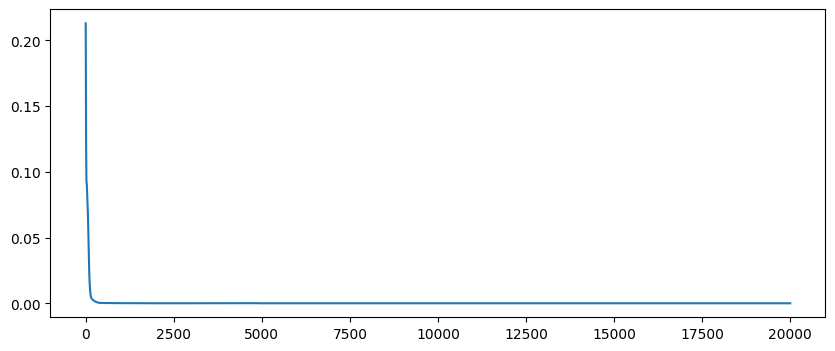

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int),train_losses)

<h2>Plot prediction</h2>

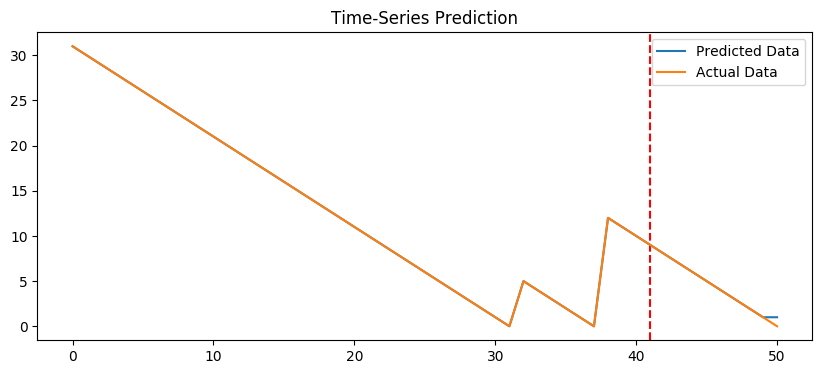

In [ ]:
# scale/unscale target and prediction for comparison
test = scale_data(data)
predicted = lstm(test)
predicted = unscale_predicted(predicted)
target = format_target(data)

plt.figure(figsize=(10,4))
plt.axvline(x=train_lim, c='r', linestyle='--')

plt.plot(predicted, label='Predicted Data')
plt.plot(target, label='Actual Data')
plt.title('Time-Series Prediction')

plt.legend()
plt.show() 

<h2>Model Accuracy</h2>

In [ ]:
# sklearn accuracy_score function
accuracy = accuracy_score(predicted,target) * 100
print('%.2f' % accuracy + '%')

98.04%


<h1>Save Model</h1>

In [ ]:
# save trained model
best_model = lstm.state_dict()
torch.save(best_model,model_path)

<h1>Final Model</h1>

<h2>Load Trained Model</h2>

In [28]:
# load trained model for predictions
model = LSTM()
model.load(model_path)
model.eval()

LSTM(
  (lstm): LSTM(4, 75, batch_first=True)
  (lin_1): Linear(in_features=75, out_features=300, bias=True)
  (lin): Linear(in_features=300, out_features=1, bias=True)
  (relu): ReLU()
)

In [29]:
# load simulation data
def get_race_data():
    return pd.read_csv(f'{val_dir}{circuit}_{year}_Test_Data.csv')

<h1>Prediction Display</h1>
<h2>Excecute cell, then move slider to select current lap and update prediction</h2>
<h3>Accuracy is calculated by dividing the predicted lap by the target (actual) lap -- presented as a percentage</h3>

In [ ]:
# Interactive widget
%matplotlib inline
@widgets.interact(lap=(5,len(get_race_data())))
def func(lap=10):
    lap=lap
    race_data = get_race_data()
    
    # get data from laps 2 thru selected lap
    race_data = race_data.loc[(race_data['lap'] > 3) & (race_data['lap'] <= lap)]
    
    # process data before feeding into model
    predicted = scale_data(race_data)
    
    # run modal and unscale the results
    predicted = model(predicted)
    predicted = unscale_predicted(predicted)
    predicted_pit = get_projected_pit_lap(predicted)

    # format actual data to compare against prediction
    target = format_target(race_data)
    target_pit = get_projected_pit_lap(target)

    print(f'Predicted Pit Stop Lap: {predicted_pit}\nTarget Pit Stop Lap: {target_pit}')
    print('Accuracy: ' + '%2.1f' %  (predicted_pit/target_pit * 100) + '%')

    plt.figure(figsize=(10,5))
    plt.plot(predicted, label = 'Predicted')
    plt.plot(target, label = 'Actual')
    plt.legend()

interactive(children=(IntSlider(value=10, description='lap', max=49, min=5), Output()), _dom_classes=('widget-…

____

___

# Install Dependancies


In [ ]:

### Only needed if fetching new race data
# !pip install fastf1
###

!pip install matplotlib
!pip install torchmetrics
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install scikit-learn
!pip install scipy
!pip install ipywidgets